In [1]:
import sys
sys.path.append('/home/kai/DAST/network')
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
import torch.utils.data.dataloader as Data
import os
import time
from torch.autograd import Variable
from DAST_utils import *
from DAST_Network import *
from torch.utils.data import TensorDataset,DataLoader
import sys
from tqdm import tqdm
import math

In [2]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
#Myscore function
def myScore(target, pred):
    print('target', target.shape)
    print('pred', pred.shape)
    Er = 100 * ((target - pred) / target)
    print(Er.shape)
    A = math.exp(-np.log(0.5) * (Er / 5)) if Er <=0 else math.exp(np.log(0.5) * (Er / 20))
    return A

In [5]:
def RMSE(target, pred):
    square_error = (target - pred) ** 2
    mse =  (torch.sum(square_error)) / len(target)
    rmse = mse ** 0.5
    return rmse

In [6]:
def MAE(target, pred):
    absolute_error = np.abs(target - pred)
    return torch.sum(absolute_error) / len(target)

In [7]:
DATA_PATH = '../../../data/10FEMTO/processed_data/'
FOLDER = 'Bearing1_1'

In [8]:
X_train_1 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_X.npy')
Y_train_1 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_Y.npy')
FOLDER = 'Bearing1_2'
X_train_2 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_X.npy')
Y_train_2 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_Y.npy')
FOLDER = 'Bearing1_4'
X_train_3 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_X.npy')
Y_train_3 = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_train_Y.npy')
FOLDER = 'Bearing1_3'
# Y_train = Y_train.transpose()
X_test = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_test_X.npy')
Y_test = np.load(f'{DATA_PATH}/{FOLDER}/{FOLDER}_test_Y.npy')

In [9]:
selected_indices = [3, 4, 8, 10, 14, 15]

In [10]:
X_train_1 = [X_train_1[:, :, i] for i in selected_indices]
X_train_1 = np.stack(X_train_1, axis=-1)
X_train_2 = [X_train_2[:, :, i] for i in selected_indices]
X_train_2 = np.stack(X_train_2, axis=-1)
X_train_3 = [X_train_3[:, :, i] for i in selected_indices]
X_train_3 = np.stack(X_train_3, axis=-1)
X_test = [X_test[:, :, i] for i in selected_indices]
X_test = np.stack(X_test, axis=-1)

In [11]:
Y_train_1 = np.reshape(Y_train_1, (len(Y_train_1), -1))
Y_train_2 = np.reshape(Y_train_2, (len(Y_train_2), -1))
Y_train_3 = np.reshape(Y_train_3, (len(Y_train_3), -1))
Y_test = np.reshape(Y_test, (len(Y_test), -1))

In [12]:
X_train = np.concatenate((X_train_1, X_train_2, X_train_3), axis=0)
Y_train = np.concatenate((Y_train_1, Y_train_2, Y_train_3), axis=0)

In [13]:
# X_np = np.load(f'../../../data/10FEMTO/processed_data/simple_data_X.npy')
# Y_np = np.load(f'../../../data/10FEMTO/processed_data/simple_data_Y.npy')
# X_train, X_test = X_train[:1600], X_test[:1600]
# Y_train, Y_test = Y_np[:1600], Y_np[:1600]
# Y_test = np.reshape(Y_test, (len(Y_test), -1))

In [14]:
X_train = Variable(torch.Tensor(X_train).float())
Y_train = Variable(torch.Tensor(Y_train).float())
X_test = Variable(torch.Tensor(X_test).float())
Y_test = Variable(torch.Tensor(Y_test).float())

In [15]:
X_train.shape

torch.Size([4982, 40, 6])

In [16]:
#Hyperparameters
FEATURE = 6
EMBEDD = 20
batch_size = 256
dim_val = FEATURE
dim_attn = EMBEDD
dim_val_t = FEATURE
dim_attn_t = EMBEDD
dim_val_s = FEATURE
dim_attn_s = EMBEDD
n_heads = 4
n_decoder_layers = 1
n_encoder_layers = 2
lr = 1e-3
epochs = 100
time_step = 40
dec_seq_len = 4
output_sequence_length = 1
input_size = 6

In [17]:
train_dataset = TensorDataset(X_train,Y_train)
train_loader = Data.DataLoader(dataset=train_dataset,batch_size = batch_size,shuffle=False)
test_dataset = TensorDataset(X_test,Y_test)
test_loader = Data.DataLoader(dataset=test_dataset,batch_size = batch_size,shuffle=False)

In [18]:
# Initialize model parameters
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# debug = True
debug = False
model = DAST(dim_val_s,dim_attn_s,dim_val_t,dim_attn_t,dim_val, dim_attn,time_step,input_size,dec_seq_len,output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, debug)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [19]:
loss_list = []
train_loss_list = []
test_loss_list = []
train_time = []
test_time = []
best_mse_loss = 10000.0
best_predict = []

In [20]:
for epoch in range(epochs):
    #training
    model.train()
    loop = tqdm(train_loader, leave=True)
    for i,(X, Y) in enumerate(loop):
        batch_X = X.to(device)
        batch_Y = Y.to(device)
        out = model(batch_X)
        loss = criterion(out, batch_Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
    loss_eopch = np.mean(np.array(loss_list))
    train_loss_list.append(loss_eopch)
    print('epoch = ',epoch,
            'train_loss = ',loss_eopch.item())

    #testing
    model.eval()
    prediction_list = []
    with torch.no_grad():
        for j ,(batch_x,batch_y) in enumerate(test_loader):
            batch_X = batch_x.to(device)
            batch_Y = batch_y.to(device)
            prediction = model(batch_X)
            # prediction[prediction<0] = 0
            prediction_list.append(prediction)

    out_batch_pre = torch.cat(prediction_list).detach().cpu()
    # prediction_tensor = torch.from_numpy(out_batch_pre)
    rmse_loss = RMSE(Y_test, out_batch_pre, )
    mae_loss = MAE(Y_test, out_batch_pre, )
    test_loss = criterion(out_batch_pre, Y_test)
    test_loss_list.append(test_loss)
    if (test_loss.item() < best_mse_loss):
        best_mse_loss = test_loss.item()
        best_predict = np.reshape(out_batch_pre, (-1)).tolist()
    print('rmse_loss = ', rmse_loss.item(),
            'mae_loss = ', mae_loss.item(),
            'mse_loss = ', test_loss.item())

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 22.06it/s]


epoch =  0 train_loss =  1.1321873689070343
rmse_loss =  0.5045490264892578 mae_loss =  0.48545822501182556 mse_loss =  0.25456973910331726


100%|██████████| 20/20 [00:00<00:00, 21.43it/s]


epoch =  1 train_loss =  0.6209527336643077
rmse_loss =  0.21130190789699554 mae_loss =  0.14173169434070587 mse_loss =  0.04464849829673767


100%|██████████| 20/20 [00:00<00:00, 20.96it/s]


epoch =  2 train_loss =  0.4240894406645869
rmse_loss =  0.1396772712469101 mae_loss =  0.08078678697347641 mse_loss =  0.01950974017381668


100%|██████████| 20/20 [00:00<00:00, 21.75it/s]


epoch =  3 train_loss =  0.32358430291787954
rmse_loss =  0.12885983288288116 mae_loss =  0.0827462375164032 mse_loss =  0.01660485565662384


100%|██████████| 20/20 [00:00<00:00, 23.40it/s]


epoch =  4 train_loss =  0.2632958677725401
rmse_loss =  0.12986509501934052 mae_loss =  0.08482762426137924 mse_loss =  0.016864944249391556


100%|██████████| 20/20 [00:00<00:00, 22.07it/s]


epoch =  5 train_loss =  0.22292430703722252
rmse_loss =  0.1258036494255066 mae_loss =  0.08103157579898834 mse_loss =  0.015826556831598282


100%|██████████| 20/20 [00:00<00:00, 22.74it/s]


epoch =  6 train_loss =  0.1940391662397555
rmse_loss =  0.12352591007947922 mae_loss =  0.07876302301883698 mse_loss =  0.015258650295436382


100%|██████████| 20/20 [00:00<00:00, 22.02it/s]


epoch =  7 train_loss =  0.17229208780445332
rmse_loss =  0.12117084860801697 mae_loss =  0.07662405073642731 mse_loss =  0.014682373963296413


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


epoch =  8 train_loss =  0.15530818872664692
rmse_loss =  0.11863259226083755 mae_loss =  0.07439330965280533 mse_loss =  0.014073691330850124


100%|██████████| 20/20 [00:00<00:00, 21.57it/s]


epoch =  9 train_loss =  0.14165704569546506
rmse_loss =  0.11638446152210236 mae_loss =  0.07233234494924545 mse_loss =  0.013545342721045017


100%|██████████| 20/20 [00:00<00:00, 21.55it/s]


epoch =  10 train_loss =  0.13042688425947827
rmse_loss =  0.11415892839431763 mae_loss =  0.07021850347518921 mse_loss =  0.013032260350883007


100%|██████████| 20/20 [00:00<00:00, 21.74it/s]


epoch =  11 train_loss =  0.12101213296919014
rmse_loss =  0.11204640567302704 mae_loss =  0.06827330589294434 mse_loss =  0.01255439780652523


100%|██████████| 20/20 [00:00<00:00, 21.04it/s]


epoch =  12 train_loss =  0.11299665303757557
rmse_loss =  0.10978051275014877 mae_loss =  0.06644618511199951 mse_loss =  0.012051761150360107


100%|██████████| 20/20 [00:00<00:00, 22.05it/s]


epoch =  13 train_loss =  0.10608227169827192
rmse_loss =  0.10762618482112885 mae_loss =  0.06492617726325989 mse_loss =  0.011583395302295685


100%|██████████| 20/20 [00:00<00:00, 21.86it/s]


epoch =  14 train_loss =  0.1000480709671198
rmse_loss =  0.10534115135669708 mae_loss =  0.06308244168758392 mse_loss =  0.011096757836639881


100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


epoch =  15 train_loss =  0.09473451964977357
rmse_loss =  0.10306807607412338 mae_loss =  0.061426885426044464 mse_loss =  0.010623028501868248


100%|██████████| 20/20 [00:00<00:00, 23.02it/s]


epoch =  16 train_loss =  0.09001943330889951
rmse_loss =  0.10157519578933716 mae_loss =  0.06022002920508385 mse_loss =  0.01031752023845911


100%|██████████| 20/20 [00:00<00:00, 21.28it/s]


epoch =  17 train_loss =  0.08580581567310017
rmse_loss =  0.09969045221805573 mae_loss =  0.05875285342335701 mse_loss =  0.009938186965882778


100%|██████████| 20/20 [00:00<00:00, 22.06it/s]


epoch =  18 train_loss =  0.0820182740261723
rmse_loss =  0.09861913323402405 mae_loss =  0.05782518535852432 mse_loss =  0.009725733660161495


100%|██████████| 20/20 [00:00<00:00, 21.83it/s]


epoch =  19 train_loss =  0.07859475238983578
rmse_loss =  0.09704163670539856 mae_loss =  0.056665293872356415 mse_loss =  0.009417079389095306


100%|██████████| 20/20 [00:00<00:00, 21.17it/s]


epoch =  20 train_loss =  0.07548716046931943
rmse_loss =  0.0958564281463623 mae_loss =  0.05568963289260864 mse_loss =  0.009188455529510975


100%|██████████| 20/20 [00:00<00:00, 21.50it/s]


epoch =  21 train_loss =  0.07265391940474564
rmse_loss =  0.09515169262886047 mae_loss =  0.05490580201148987 mse_loss =  0.009053844958543777


100%|██████████| 20/20 [00:00<00:00, 20.50it/s]


epoch =  22 train_loss =  0.07006134856353088
rmse_loss =  0.09400565177202225 mae_loss =  0.05406035855412483 mse_loss =  0.008837062865495682


100%|██████████| 20/20 [00:00<00:00, 21.93it/s]


epoch =  23 train_loss =  0.06767993527591898
rmse_loss =  0.09320561587810516 mae_loss =  0.05327235162258148 mse_loss =  0.008687286637723446


100%|██████████| 20/20 [00:00<00:00, 22.18it/s]


epoch =  24 train_loss =  0.0654859648818383
rmse_loss =  0.09251490980386734 mae_loss =  0.052667051553726196 mse_loss =  0.008559008128941059


100%|██████████| 20/20 [00:00<00:00, 21.02it/s]


epoch =  25 train_loss =  0.0634579283405261
rmse_loss =  0.09185752272605896 mae_loss =  0.052016470581293106 mse_loss =  0.008437804877758026


100%|██████████| 20/20 [00:00<00:00, 22.34it/s]


epoch =  26 train_loss =  0.061577447185764966
rmse_loss =  0.09162966161966324 mae_loss =  0.0516277551651001 mse_loss =  0.008395995013415813


100%|██████████| 20/20 [00:00<00:00, 22.58it/s]


epoch =  27 train_loss =  0.059828499390381956
rmse_loss =  0.09107812494039536 mae_loss =  0.05115382373332977 mse_loss =  0.008295224979519844


100%|██████████| 20/20 [00:00<00:00, 22.00it/s]


epoch =  28 train_loss =  0.05819836906107255
rmse_loss =  0.09071814268827438 mae_loss =  0.05081813409924507 mse_loss =  0.008229781873524189


100%|██████████| 20/20 [00:00<00:00, 21.99it/s]


epoch =  29 train_loss =  0.056675201379791054
rmse_loss =  0.09028913825750351 mae_loss =  0.05044165626168251 mse_loss =  0.008152129128575325


100%|██████████| 20/20 [00:00<00:00, 21.02it/s]


epoch =  30 train_loss =  0.05524893856941602
rmse_loss =  0.08985019475221634 mae_loss =  0.05004749819636345 mse_loss =  0.008073057979345322


100%|██████████| 20/20 [00:00<00:00, 21.72it/s]


epoch =  31 train_loss =  0.05391028821272812
rmse_loss =  0.08956891298294067 mae_loss =  0.04973718523979187 mse_loss =  0.008022589609026909


100%|██████████| 20/20 [00:00<00:00, 21.74it/s]


epoch =  32 train_loss =  0.05265119664889591
rmse_loss =  0.08938755840063095 mae_loss =  0.04947706684470177 mse_loss =  0.007990135811269283


100%|██████████| 20/20 [00:00<00:00, 22.02it/s]


epoch =  33 train_loss =  0.05146457361269687
rmse_loss =  0.08920911699533463 mae_loss =  0.04926372691988945 mse_loss =  0.007958265952765942


100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


epoch =  34 train_loss =  0.0503442540848794
rmse_loss =  0.08908390253782272 mae_loss =  0.049032874405384064 mse_loss =  0.007935942150652409


100%|██████████| 20/20 [00:00<00:00, 22.02it/s]


epoch =  35 train_loss =  0.04928471145992969
rmse_loss =  0.08904839307069778 mae_loss =  0.048883579671382904 mse_loss =  0.00792961660772562


100%|██████████| 20/20 [00:00<00:00, 22.82it/s]


epoch =  36 train_loss =  0.048280831034384936
rmse_loss =  0.08910539001226425 mae_loss =  0.04874284565448761 mse_loss =  0.007939770817756653


100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


epoch =  37 train_loss =  0.04732819331119045
rmse_loss =  0.08922479301691055 mae_loss =  0.04866303130984306 mse_loss =  0.007961063645780087


100%|██████████| 20/20 [00:00<00:00, 21.01it/s]


epoch =  38 train_loss =  0.046422862513766934
rmse_loss =  0.08948127925395966 mae_loss =  0.04863100126385689 mse_loss =  0.008006899617612362


100%|██████████| 20/20 [00:00<00:00, 21.78it/s]


epoch =  39 train_loss =  0.04556117925054423
rmse_loss =  0.08985812962055206 mae_loss =  0.048680439591407776 mse_loss =  0.008074482902884483


100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


epoch =  40 train_loss =  0.044739826563880605
rmse_loss =  0.09058666229248047 mae_loss =  0.04881678521633148 mse_loss =  0.008205942809581757


100%|██████████| 20/20 [00:00<00:00, 22.58it/s]


epoch =  41 train_loss =  0.043956796148857044
rmse_loss =  0.0913991928100586 mae_loss =  0.049009326845407486 mse_loss =  0.008353812620043755


100%|██████████| 20/20 [00:00<00:00, 22.71it/s]


epoch =  42 train_loss =  0.04320773661785034
rmse_loss =  0.09248463064432144 mae_loss =  0.049393534660339355 mse_loss =  0.008553407154977322


100%|██████████| 20/20 [00:00<00:00, 21.48it/s]


epoch =  43 train_loss =  0.04249040516832875
rmse_loss =  0.09358150511980057 mae_loss =  0.0498020276427269 mse_loss =  0.008757498115301132


100%|██████████| 20/20 [00:00<00:00, 21.28it/s]


epoch =  44 train_loss =  0.04180298691327658
rmse_loss =  0.09527086466550827 mae_loss =  0.05038929358124733 mse_loss =  0.009076537564396858


100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


epoch =  45 train_loss =  0.04114372043623007
rmse_loss =  0.09715095907449722 mae_loss =  0.051117923110723495 mse_loss =  0.009438308887183666


100%|██████████| 20/20 [00:00<00:00, 22.05it/s]


epoch =  46 train_loss =  0.040509995764048345
rmse_loss =  0.09923689812421799 mae_loss =  0.05199830234050751 mse_loss =  0.00984796229749918


100%|██████████| 20/20 [00:00<00:00, 20.13it/s]


epoch =  47 train_loss =  0.03990000922867694
rmse_loss =  0.10153113305568695 mae_loss =  0.05299418792128563 mse_loss =  0.010308570228517056


100%|██████████| 20/20 [00:00<00:00, 22.19it/s]


epoch =  48 train_loss =  0.03931276164105523
rmse_loss =  0.1045120358467102 mae_loss =  0.05426783859729767 mse_loss =  0.010922765359282494


100%|██████████| 20/20 [00:00<00:00, 22.02it/s]


epoch =  49 train_loss =  0.03874685530766146
rmse_loss =  0.10766000300645828 mae_loss =  0.05563352629542351 mse_loss =  0.011590675450861454


100%|██████████| 20/20 [00:00<00:00, 21.10it/s]


epoch =  50 train_loss =  0.03820109392596779
rmse_loss =  0.11077182739973068 mae_loss =  0.056868962943553925 mse_loss =  0.012270397506654263


100%|██████████| 20/20 [00:00<00:00, 20.73it/s]


epoch =  51 train_loss =  0.03767394998964077
rmse_loss =  0.11517897248268127 mae_loss =  0.058630019426345825 mse_loss =  0.01326619554311037


100%|██████████| 20/20 [00:00<00:00, 22.54it/s]


epoch =  52 train_loss =  0.03716389054501427
rmse_loss =  0.12003640085458755 mae_loss =  0.06075925752520561 mse_loss =  0.014408737421035767


100%|██████████| 20/20 [00:00<00:00, 22.07it/s]


epoch =  53 train_loss =  0.03666998879832843
rmse_loss =  0.11925764381885529 mae_loss =  0.060594342648983 mse_loss =  0.014222385361790657


100%|██████████| 20/20 [00:00<00:00, 21.21it/s]


epoch =  54 train_loss =  0.03620841799461315
rmse_loss =  0.13855154812335968 mae_loss =  0.06947480142116547 mse_loss =  0.019196532666683197


100%|██████████| 20/20 [00:00<00:00, 21.11it/s]


epoch =  55 train_loss =  0.03574831626910964
rmse_loss =  0.13818444311618805 mae_loss =  0.06872329115867615 mse_loss =  0.019094940274953842


100%|██████████| 20/20 [00:00<00:00, 20.77it/s]


epoch =  56 train_loss =  0.03530115192561265
rmse_loss =  0.12473120540380478 mae_loss =  0.06329143047332764 mse_loss =  0.01555787306278944


100%|██████████| 20/20 [00:00<00:00, 21.61it/s]


epoch =  57 train_loss =  0.03486527202056033
rmse_loss =  0.12002049386501312 mae_loss =  0.061981670558452606 mse_loss =  0.014404918067157269


100%|██████████| 20/20 [00:00<00:00, 21.51it/s]


epoch =  58 train_loss =  0.034440975978657785
rmse_loss =  0.11361723393201828 mae_loss =  0.058703143149614334 mse_loss =  0.01290887501090765


100%|██████████| 20/20 [00:00<00:00, 21.94it/s]


epoch =  59 train_loss =  0.034050784821459575
rmse_loss =  0.16574369370937347 mae_loss =  0.08157333731651306 mse_loss =  0.027470970526337624


100%|██████████| 20/20 [00:00<00:00, 22.11it/s]


epoch =  60 train_loss =  0.03366023487109428
rmse_loss =  0.16236913204193115 mae_loss =  0.07956376671791077 mse_loss =  0.026363736018538475


100%|██████████| 20/20 [00:00<00:00, 21.21it/s]


epoch =  61 train_loss =  0.03329264169836777
rmse_loss =  0.10056962817907333 mae_loss =  0.05518443509936333 mse_loss =  0.010114249773323536


100%|██████████| 20/20 [00:00<00:00, 21.66it/s]


epoch =  62 train_loss =  0.032936124747287805
rmse_loss =  0.12388662248849869 mae_loss =  0.06305184215307236 mse_loss =  0.01534789614379406


100%|██████████| 20/20 [00:00<00:00, 22.22it/s]


epoch =  63 train_loss =  0.032594876482960444
rmse_loss =  0.18592214584350586 mae_loss =  0.0919647067785263 mse_loss =  0.03456704691052437


100%|██████████| 20/20 [00:00<00:00, 20.79it/s]


epoch =  64 train_loss =  0.03226205831757398
rmse_loss =  0.13119548559188843 mae_loss =  0.0656450167298317 mse_loss =  0.01721225492656231


100%|██████████| 20/20 [00:00<00:00, 21.16it/s]


epoch =  65 train_loss =  0.031921348198915386
rmse_loss =  0.10747918486595154 mae_loss =  0.057486385107040405 mse_loss =  0.011551775969564915


100%|██████████| 20/20 [00:00<00:00, 22.09it/s]


epoch =  66 train_loss =  0.03159753405579706
rmse_loss =  0.13760189712047577 mae_loss =  0.06690123677253723 mse_loss =  0.018934281542897224


100%|██████████| 20/20 [00:00<00:00, 22.20it/s]


epoch =  67 train_loss =  0.03127571481120279
rmse_loss =  0.15964090824127197 mae_loss =  0.07793448120355606 mse_loss =  0.025485221296548843


100%|██████████| 20/20 [00:00<00:00, 21.87it/s]


epoch =  68 train_loss =  0.03096472224603096
rmse_loss =  0.1175786554813385 mae_loss =  0.0597471185028553 mse_loss =  0.013824740424752235


100%|██████████| 20/20 [00:00<00:00, 22.04it/s]


epoch =  69 train_loss =  0.03065336790979927
rmse_loss =  0.1023983582854271 mae_loss =  0.05464215949177742 mse_loss =  0.010485423728823662


100%|██████████| 20/20 [00:00<00:00, 22.27it/s]


epoch =  70 train_loss =  0.030371349375352918
rmse_loss =  0.1552220582962036 mae_loss =  0.07625836879014969 mse_loss =  0.024093886837363243


100%|██████████| 20/20 [00:00<00:00, 21.56it/s]


epoch =  71 train_loss =  0.030080472857919933
rmse_loss =  0.15855757892131805 mae_loss =  0.07794686406850815 mse_loss =  0.02514050528407097


100%|██████████| 20/20 [00:00<00:00, 20.88it/s]


epoch =  72 train_loss =  0.02981267173487788
rmse_loss =  0.10828252881765366 mae_loss =  0.05695992335677147 mse_loss =  0.01172510627657175


100%|██████████| 20/20 [00:00<00:00, 22.41it/s]


epoch =  73 train_loss =  0.029546318144182168
rmse_loss =  0.11953707784414291 mae_loss =  0.0598413422703743 mse_loss =  0.014289112761616707


100%|██████████| 20/20 [00:00<00:00, 22.26it/s]


epoch =  74 train_loss =  0.02928084648497073
rmse_loss =  0.14653901755809784 mae_loss =  0.0720147043466568 mse_loss =  0.021473683416843414


100%|██████████| 20/20 [00:00<00:00, 21.47it/s]


epoch =  75 train_loss =  0.02901933919076902
rmse_loss =  0.12123420089483261 mae_loss =  0.06121980398893356 mse_loss =  0.014697731472551823


100%|██████████| 20/20 [00:00<00:00, 22.03it/s]


epoch =  76 train_loss =  0.028758099173548497
rmse_loss =  0.10469035804271698 mae_loss =  0.05490448325872421 mse_loss =  0.010960071347653866


100%|██████████| 20/20 [00:00<00:00, 22.15it/s]


epoch =  77 train_loss =  0.02851989640857937
rmse_loss =  0.15105339884757996 mae_loss =  0.07479008287191391 mse_loss =  0.022817129269242287


100%|██████████| 20/20 [00:00<00:00, 21.90it/s]


epoch =  78 train_loss =  0.028274434048879915
rmse_loss =  0.15394291281700134 mae_loss =  0.07613781839609146 mse_loss =  0.023698419332504272


100%|██████████| 20/20 [00:00<00:00, 22.24it/s]


epoch =  79 train_loss =  0.028050381927459966
rmse_loss =  0.10691642761230469 mae_loss =  0.05590858682990074 mse_loss =  0.01143112313002348


100%|██████████| 20/20 [00:00<00:00, 21.90it/s]


epoch =  80 train_loss =  0.02782820782047139
rmse_loss =  0.12740975618362427 mae_loss =  0.06355810165405273 mse_loss =  0.01623324491083622


100%|██████████| 20/20 [00:00<00:00, 22.50it/s]


epoch =  81 train_loss =  0.027600118935826198
rmse_loss =  0.13707543909549713 mae_loss =  0.06759574264287949 mse_loss =  0.01878967694938183


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


epoch =  82 train_loss =  0.02737851131738813
rmse_loss =  0.11301537603139877 mae_loss =  0.057808976620435715 mse_loss =  0.012772474437952042


100%|██████████| 20/20 [00:00<00:00, 22.68it/s]


epoch =  83 train_loss =  0.027156848400638756
rmse_loss =  0.10432133078575134 mae_loss =  0.05451260134577751 mse_loss =  0.010882940143346786


100%|██████████| 20/20 [00:00<00:00, 21.66it/s]


epoch =  84 train_loss =  0.02695270473857818
rmse_loss =  0.14976373314857483 mae_loss =  0.07471036165952682 mse_loss =  0.022429173812270164


100%|██████████| 20/20 [00:00<00:00, 22.27it/s]


epoch =  85 train_loss =  0.026742324389450133
rmse_loss =  0.13430503010749817 mae_loss =  0.06699367612600327 mse_loss =  0.018037842586636543


100%|██████████| 20/20 [00:00<00:00, 22.22it/s]


epoch =  86 train_loss =  0.02654205944110862
rmse_loss =  0.10198098421096802 mae_loss =  0.05380512401461601 mse_loss =  0.010400121100246906


100%|██████████| 20/20 [00:00<00:00, 22.09it/s]


epoch =  87 train_loss =  0.0263506610782687
rmse_loss =  0.11997843533754349 mae_loss =  0.060162682086229324 mse_loss =  0.014394824393093586


100%|██████████| 20/20 [00:00<00:00, 21.66it/s]


epoch =  88 train_loss =  0.026159744527013685
rmse_loss =  0.15056464076042175 mae_loss =  0.07518444210290909 mse_loss =  0.022669712081551552


100%|██████████| 20/20 [00:00<00:00, 22.88it/s]


epoch =  89 train_loss =  0.025975572175755385
rmse_loss =  0.11262587457895279 mae_loss =  0.056617531925439835 mse_loss =  0.012684587389230728


100%|██████████| 20/20 [00:00<00:00, 22.50it/s]


epoch =  90 train_loss =  0.025785937457144577
rmse_loss =  0.10245151072740555 mae_loss =  0.054002273827791214 mse_loss =  0.010496311821043491


100%|██████████| 20/20 [00:00<00:00, 21.33it/s]


epoch =  91 train_loss =  0.02560797828401796
rmse_loss =  0.1385488063097 mae_loss =  0.06904393434524536 mse_loss =  0.01919577270746231


100%|██████████| 20/20 [00:00<00:00, 21.44it/s]


epoch =  92 train_loss =  0.02542577838145418
rmse_loss =  0.12670965492725372 mae_loss =  0.0631573274731636 mse_loss =  0.016055336222052574


100%|██████████| 20/20 [00:00<00:00, 22.71it/s]


epoch =  93 train_loss =  0.025249804537080752
rmse_loss =  0.09927091002464294 mae_loss =  0.05253787338733673 mse_loss =  0.009854713454842567


100%|██████████| 20/20 [00:00<00:00, 23.21it/s]


epoch =  94 train_loss =  0.025083891987079894
rmse_loss =  0.12063566595315933 mae_loss =  0.060762230306863785 mse_loss =  0.014552963897585869


100%|██████████| 20/20 [00:00<00:00, 23.55it/s]


epoch =  95 train_loss =  0.02491639278750881
rmse_loss =  0.1449517458677292 mae_loss =  0.07250671088695526 mse_loss =  0.02101100981235504


100%|██████████| 20/20 [00:00<00:00, 23.50it/s]


epoch =  96 train_loss =  0.024758000146659433
rmse_loss =  0.1088118702173233 mae_loss =  0.0546921081840992 mse_loss =  0.01184002310037613


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


epoch =  97 train_loss =  0.024594869706706216
rmse_loss =  0.10739472508430481 mae_loss =  0.05566486716270447 mse_loss =  0.011533627286553383


100%|██████████| 20/20 [00:00<00:00, 22.07it/s]


epoch =  98 train_loss =  0.02443682684580298
rmse_loss =  0.1324348747730255 mae_loss =  0.06613036245107651 mse_loss =  0.017538996413350105


100%|██████████| 20/20 [00:00<00:00, 24.30it/s]

epoch =  99 train_loss =  0.024277942589447776
rmse_loss =  0.117189921438694 mae_loss =  0.05847570672631264 mse_loss =  0.013733478263020515


In [21]:
print(best_mse_loss)

0.00792961660772562


In [22]:
z = np.reshape(out_batch_pre, (-1))
z = z.tolist()

In [23]:
y = Y_test.detach().cpu().numpy()
y = np.reshape(y, -1)
y = y.tolist()

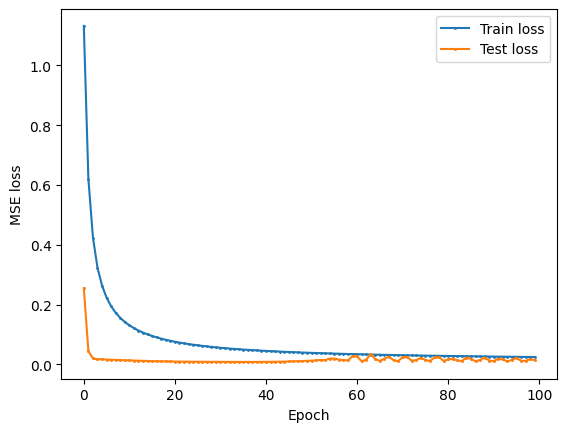

In [24]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(train_loss_list, label='Train loss', marker='o', markersize=1)
plt.plot(test_loss_list, label='Test loss', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
# Adding a legend
plt.legend()

# Display the plot
plt.show()

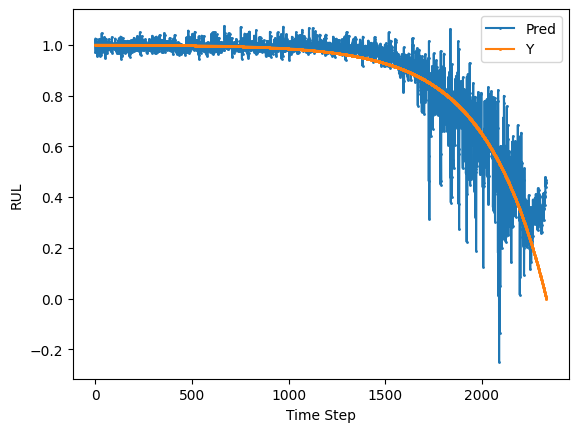

In [25]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(best_predict, label='Pred', marker='o', markersize=1)
plt.plot(y, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('RUL')
# Adding a legend
plt.legend()

# Display the plot
plt.show()

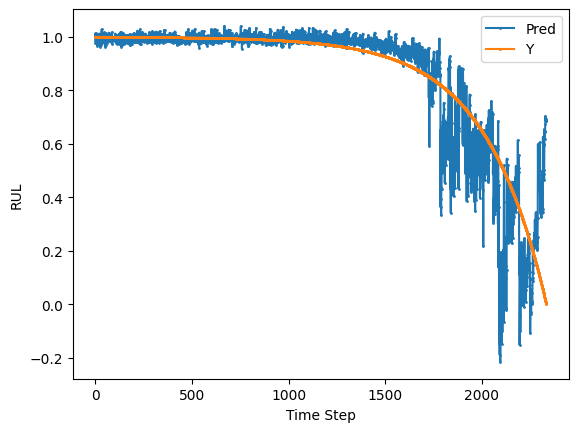

In [26]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(z, label='Pred', marker='o', markersize=1)
plt.plot(y, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('Time Step')
plt.ylabel('RUL')
# Adding a legend
plt.legend()

# Display the plot
plt.show()

In [27]:
# run above

# RUN above

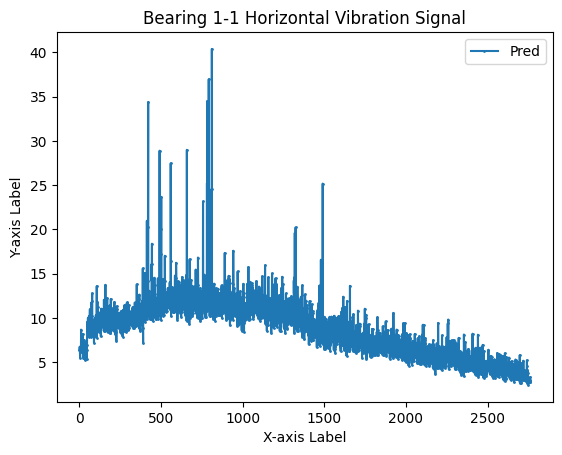

In [28]:
import matplotlib.pyplot as plt
# Example data
X_draw = X_train[:2763, 0, 4]
# Plotting the line chart
plt.plot(X_draw, label='Pred', marker='o', markersize=1)
# plt.plot(Y_test, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Bearing 1-1 Horizontal Vibration Signal')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

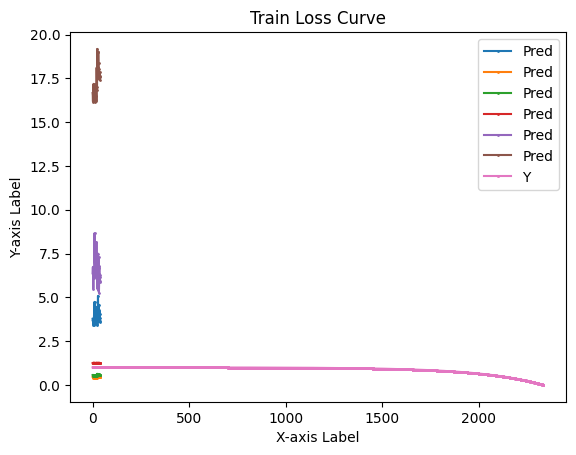

In [29]:
import matplotlib.pyplot as plt

# Example data

# Plotting the line chart
plt.plot(X_train[0], label='Pred', marker='o', markersize=1)
plt.plot(Y_test, label='Y', marker='s', markersize=1)
# Adding labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Train Loss Curve')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

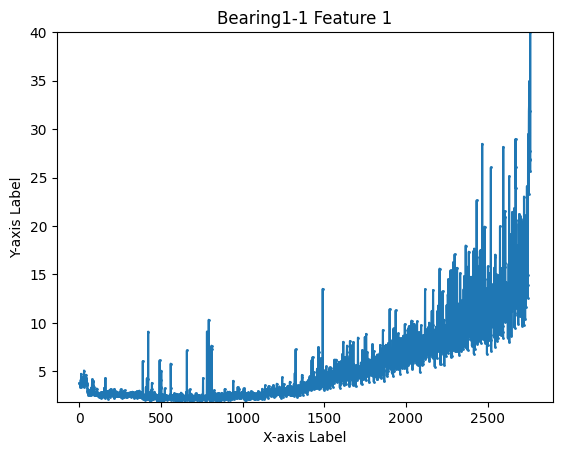

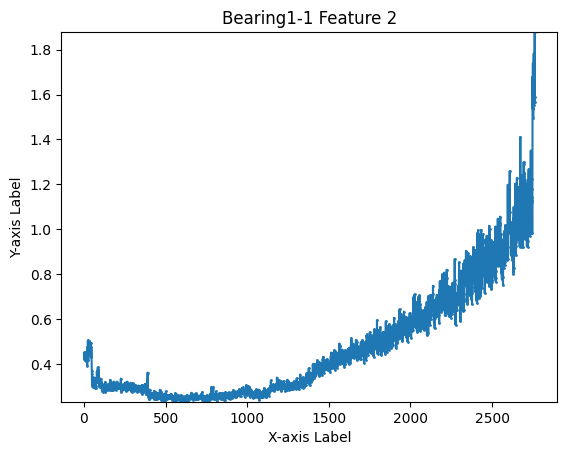

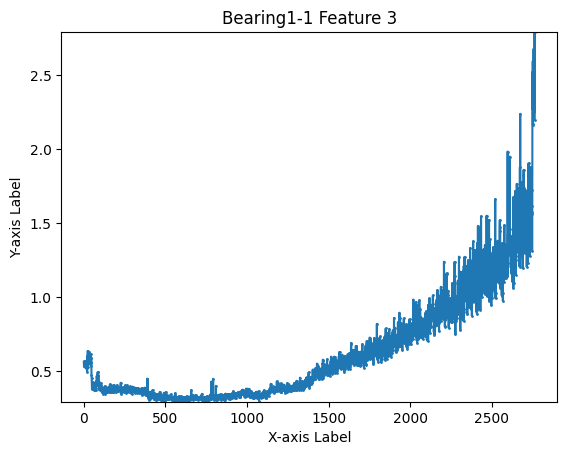

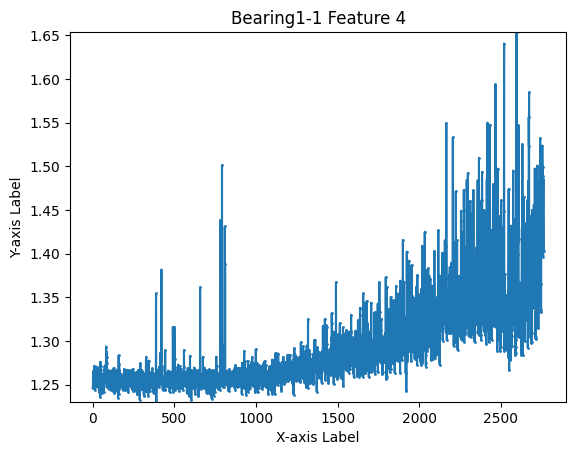

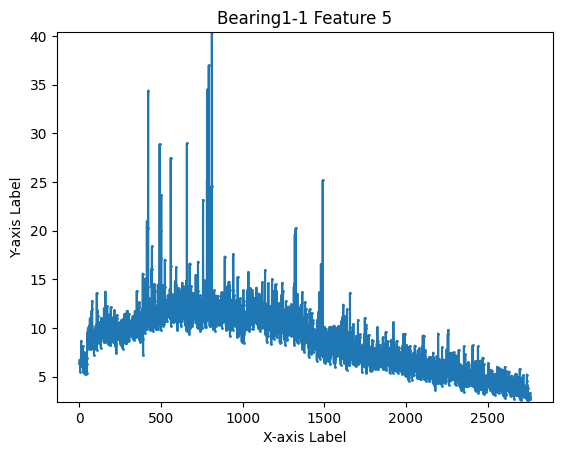

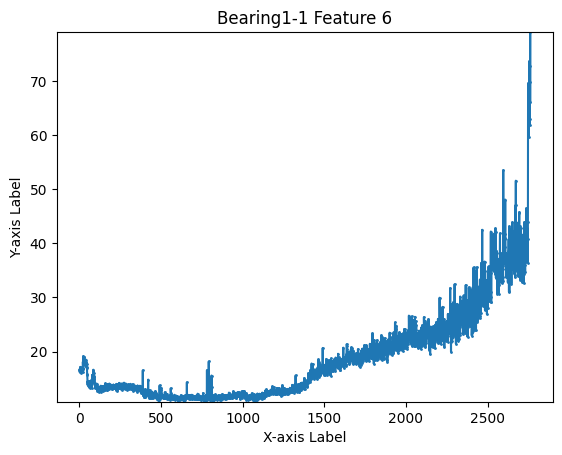

IndexError: index 6 is out of bounds for axis 2 with size 6

In [30]:
import matplotlib.pyplot as plt

for i in range(20):
    plt.plot(X_train_1[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_1[:, 0, i]), max(X_train_1[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-1 Feature {i+1}')
    plt.show()

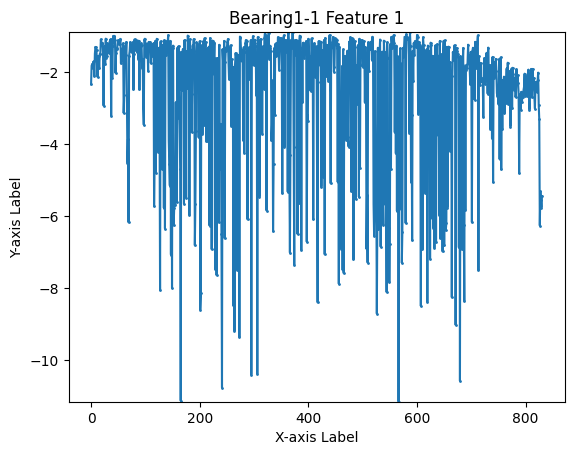

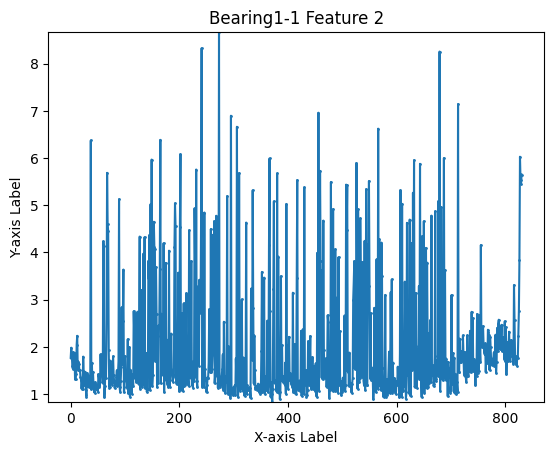

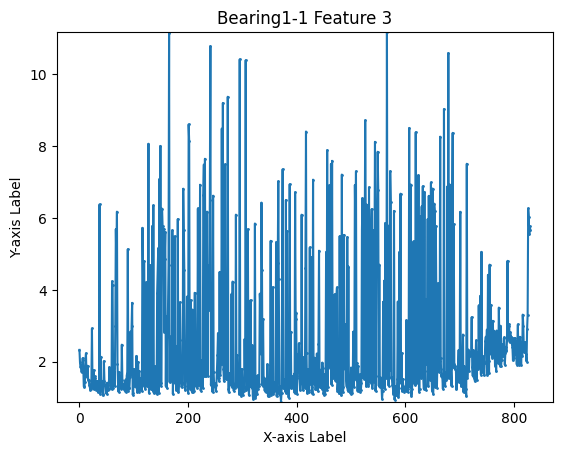

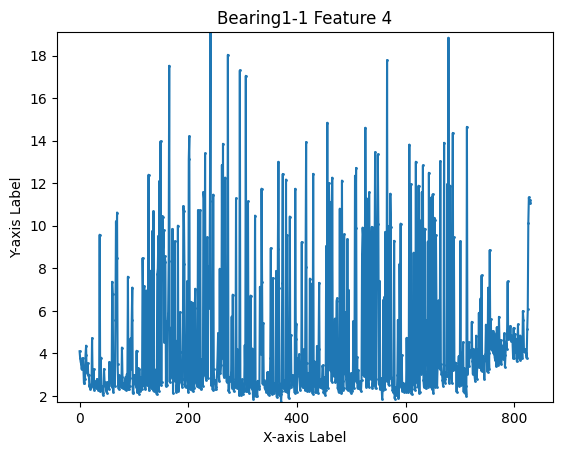

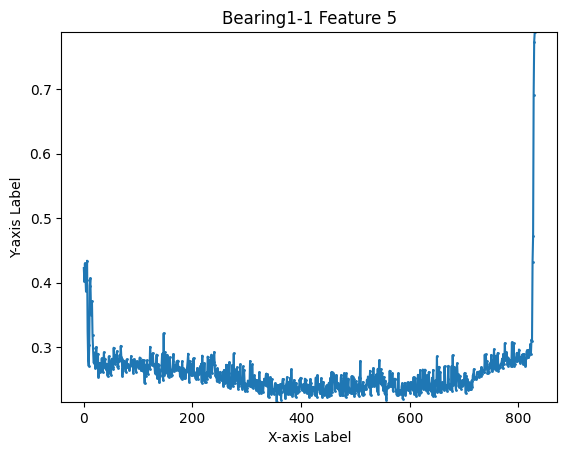

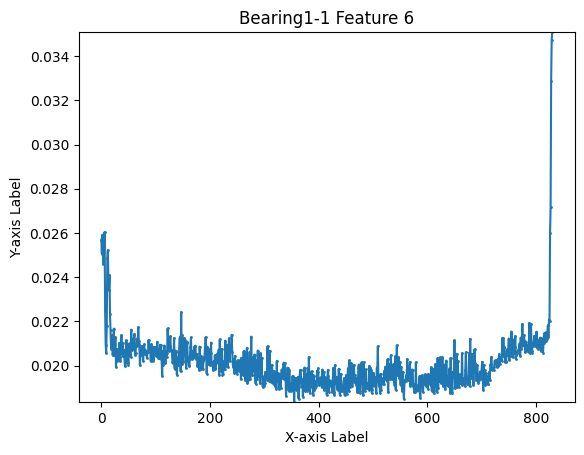

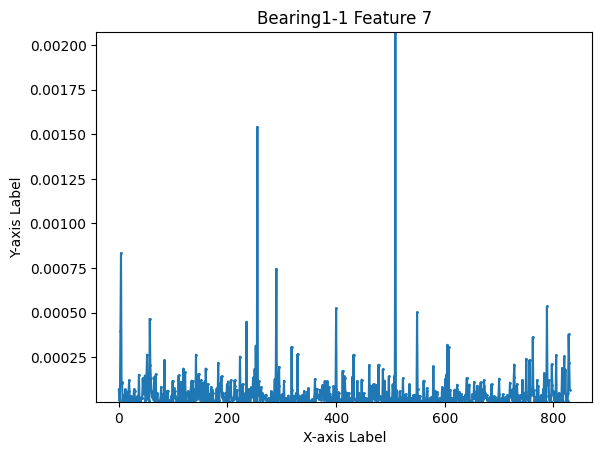

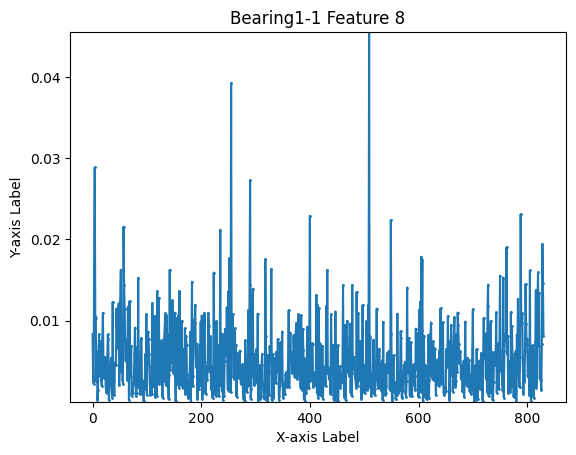

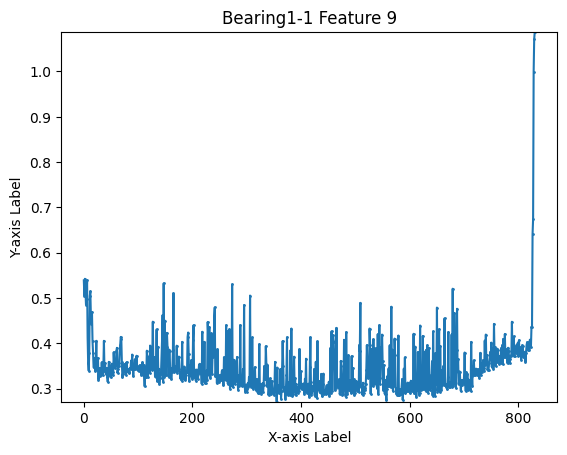

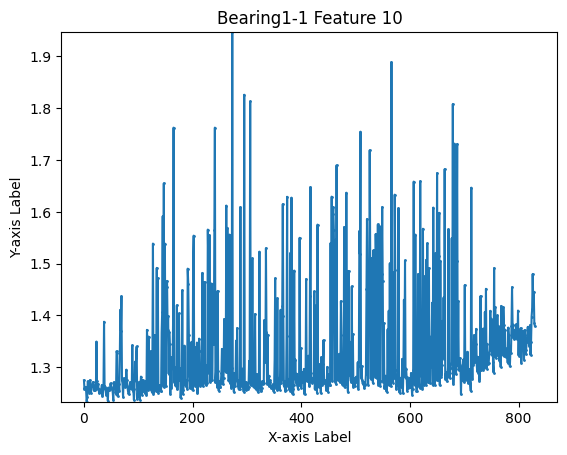

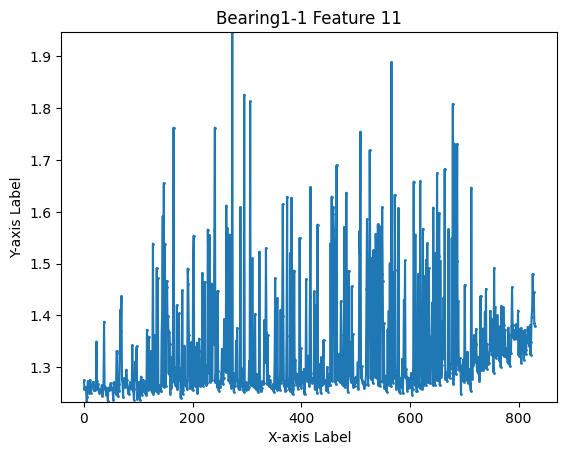

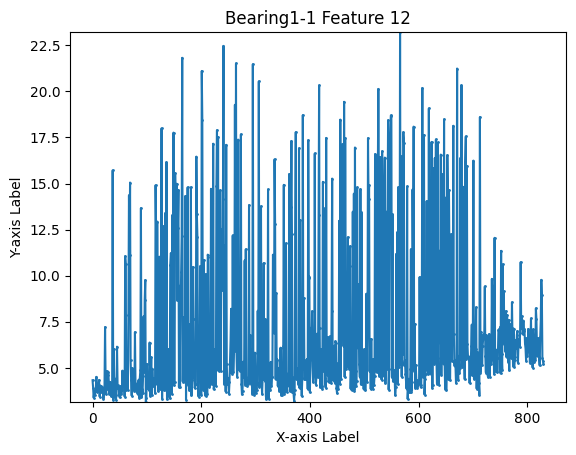

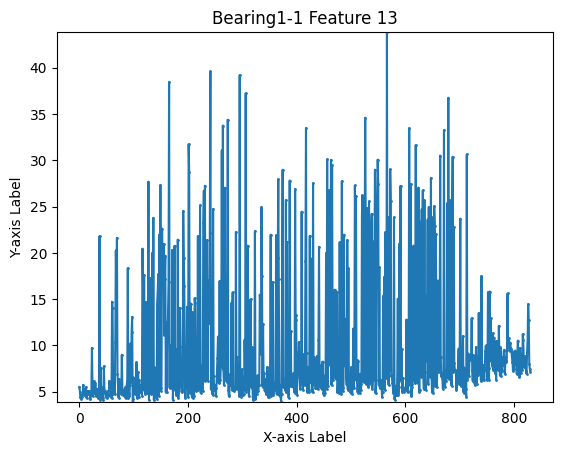

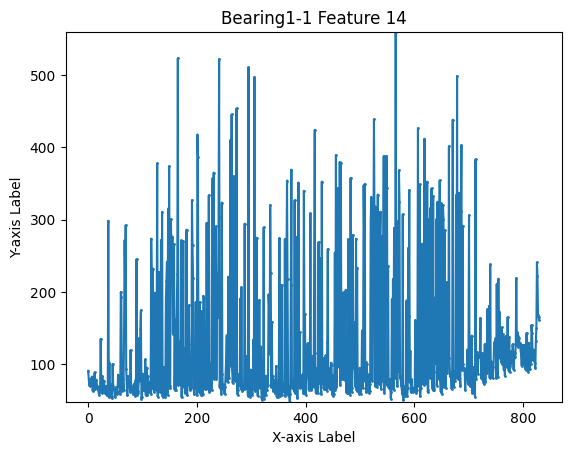

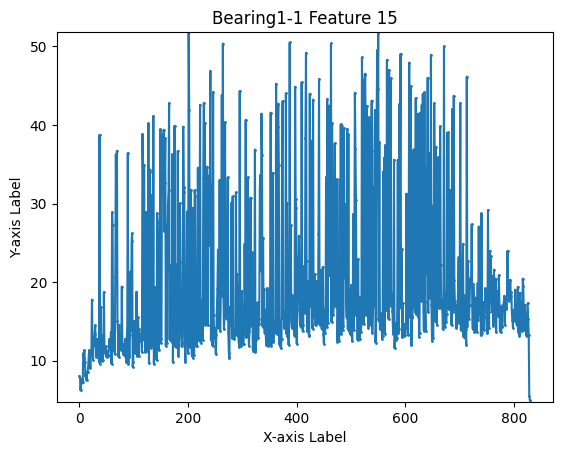

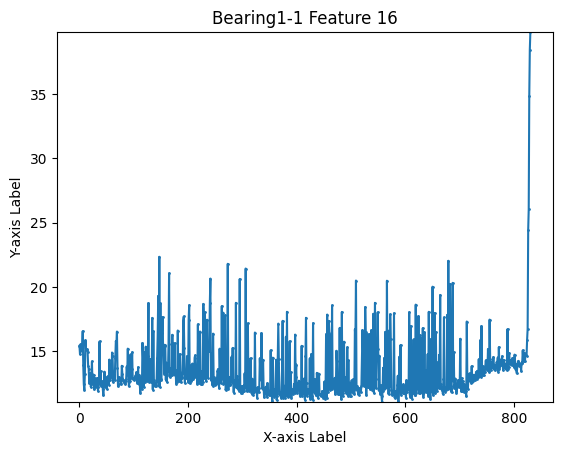

IndexError: index 16 is out of bounds for axis 2 with size 16

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_train_2[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_2[:, 0, i]), max(X_train_2[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-2 Feature {i+1}')
    # Display the plot
    plt.show()

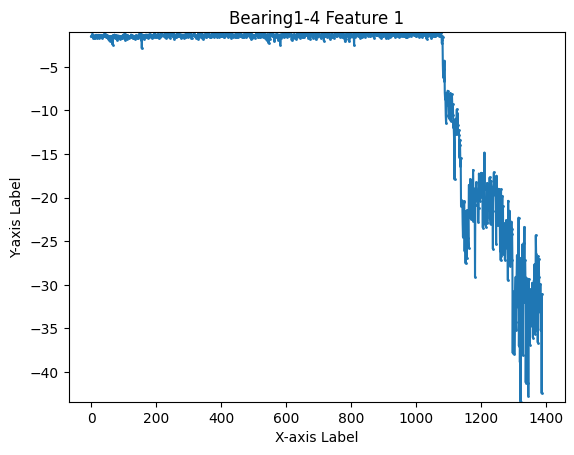

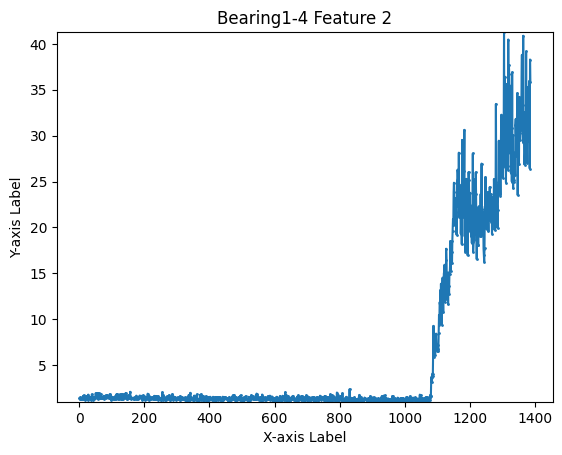

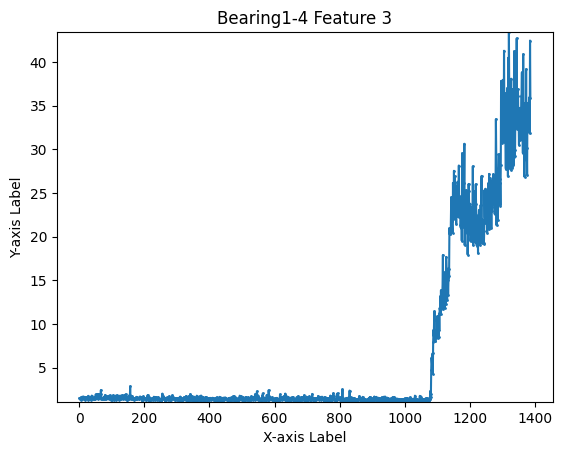

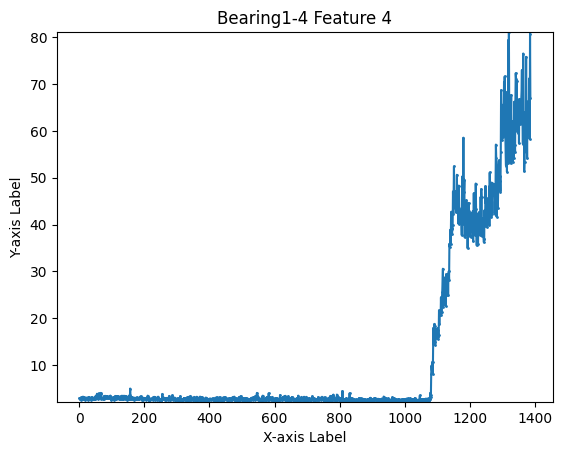

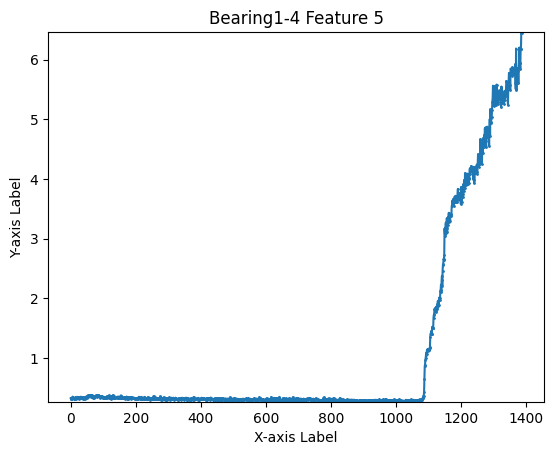

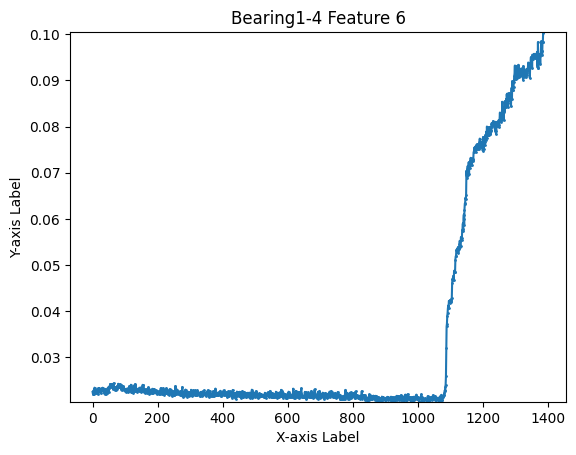

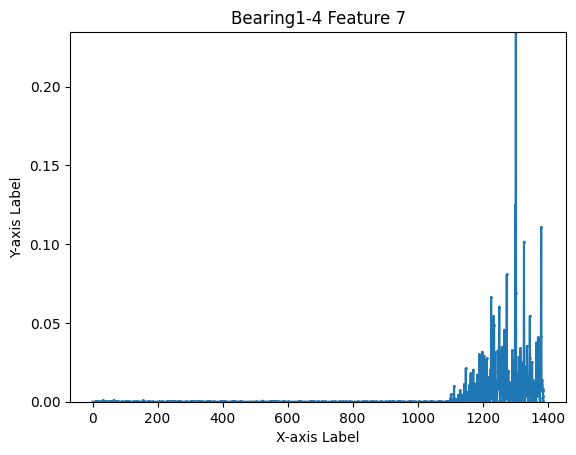

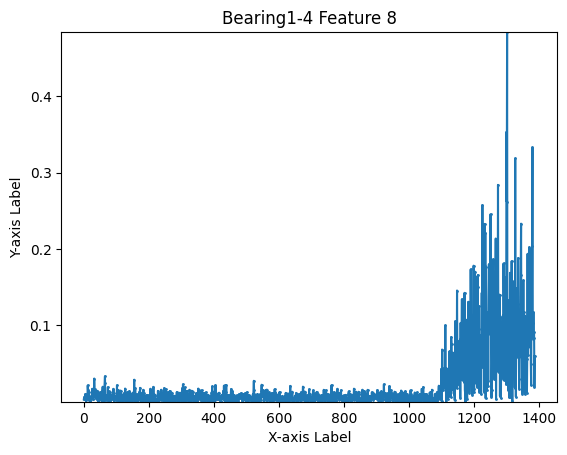

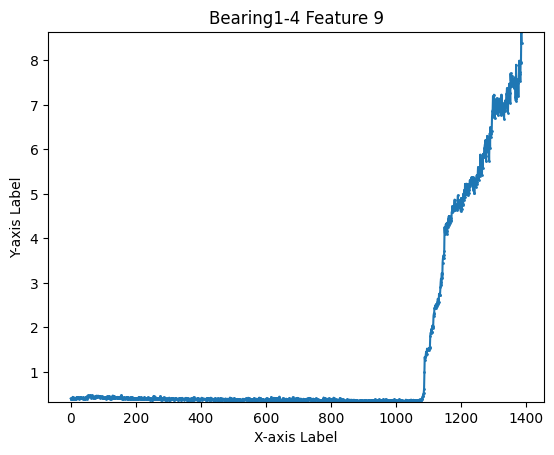

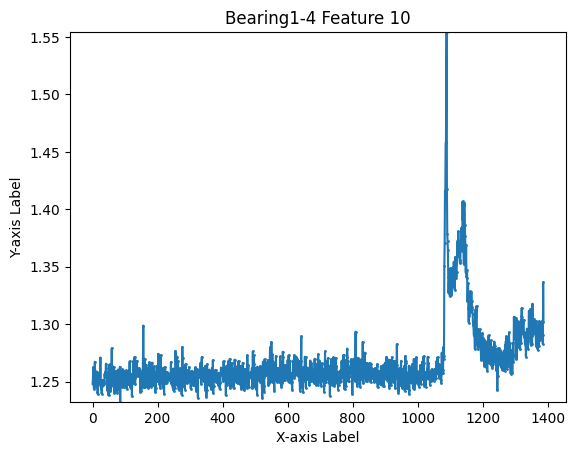

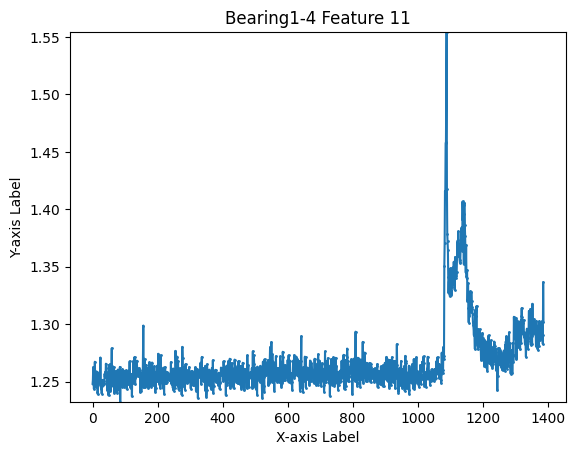

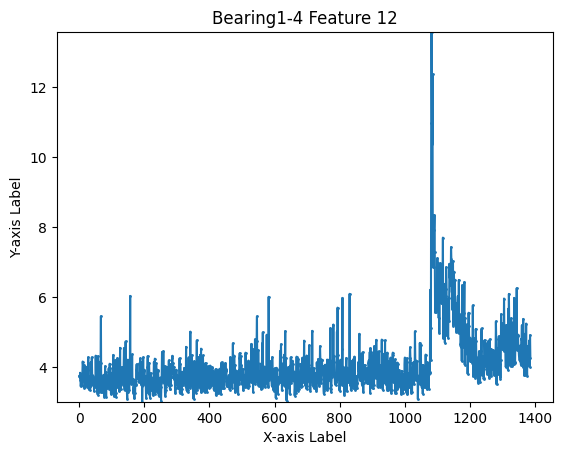

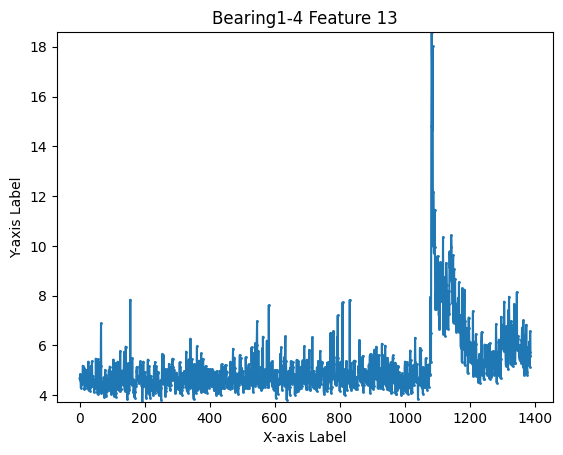

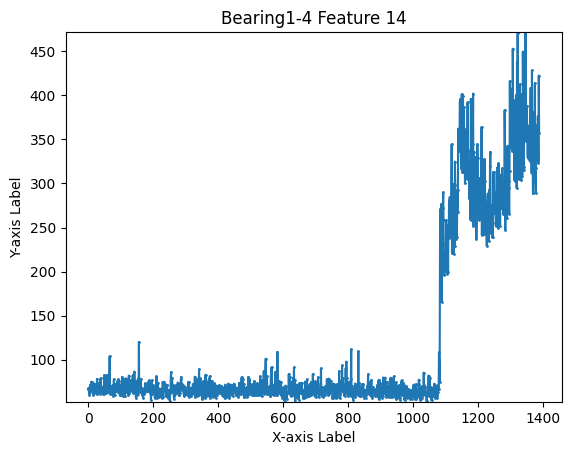

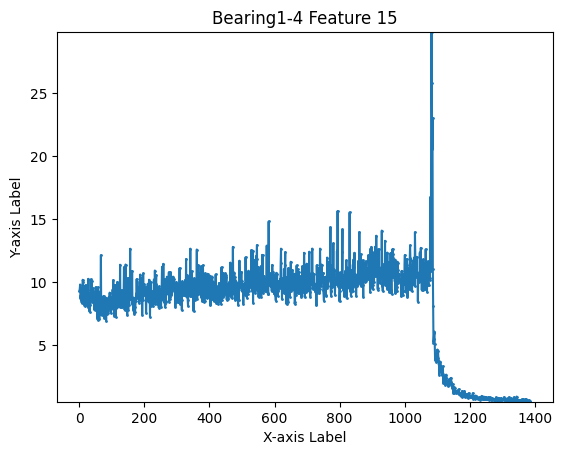

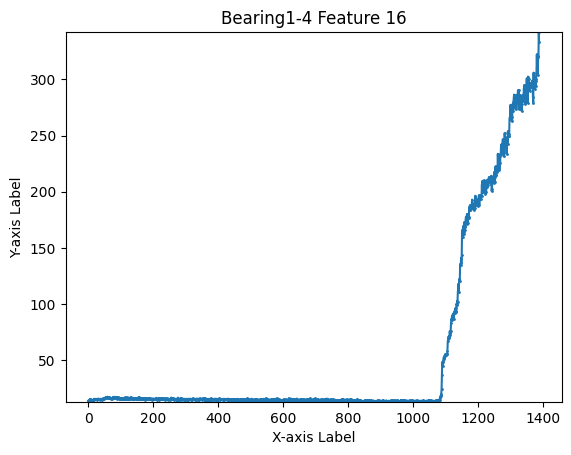

IndexError: index 16 is out of bounds for axis 2 with size 16

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_train_3[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_train_3[:, 0, i]), max(X_train_3[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-4 Feature {i+1}')
    # Display the plot
    plt.show()

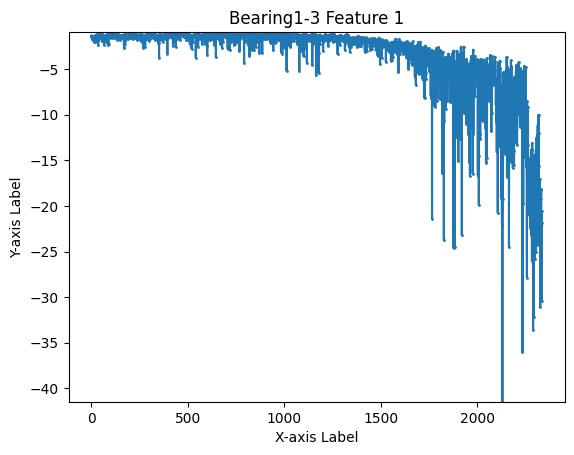

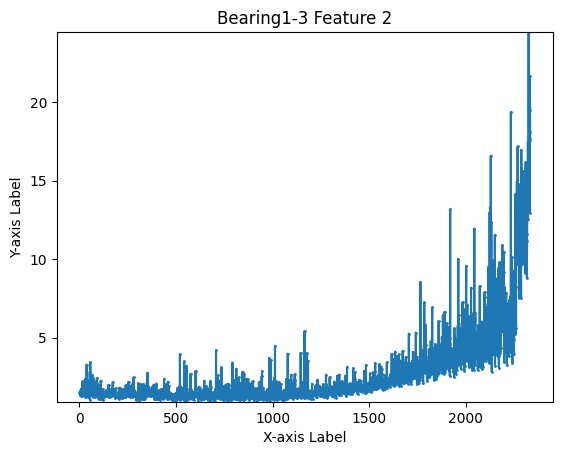

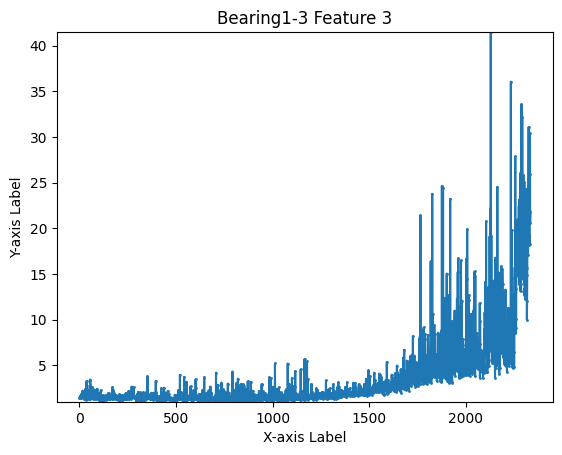

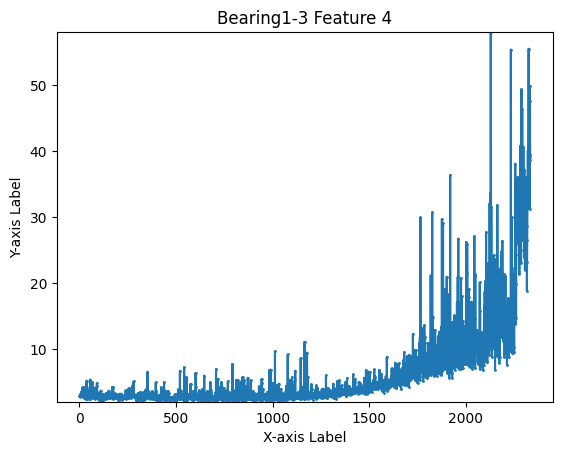

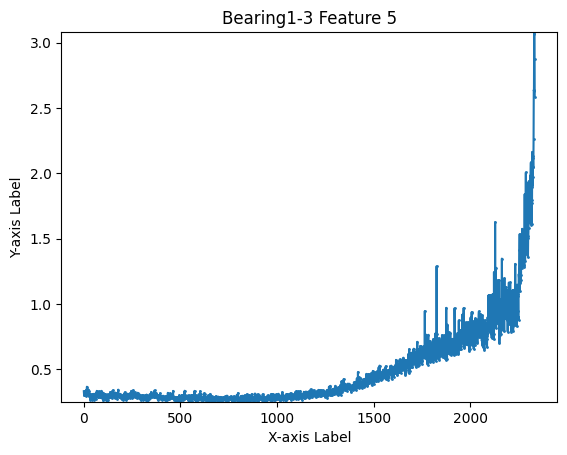

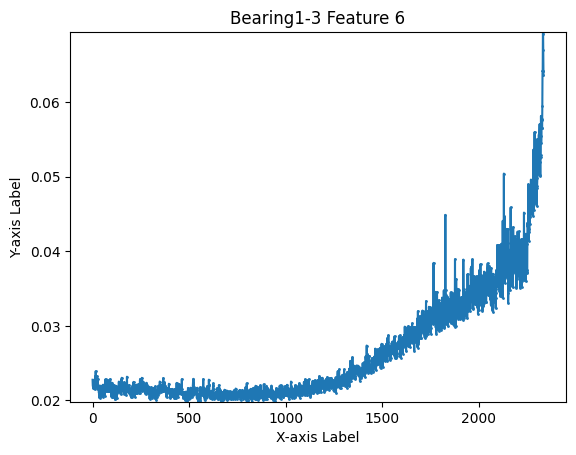

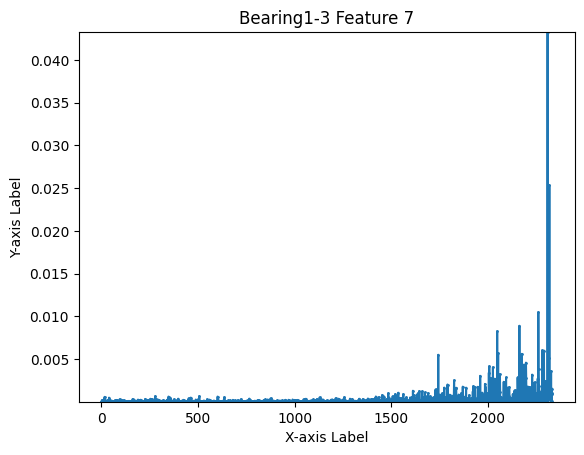

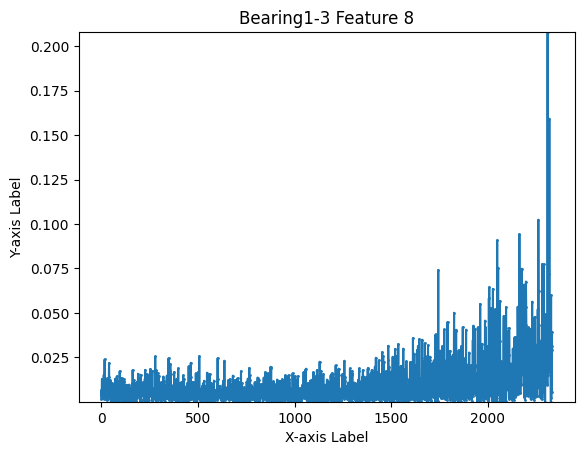

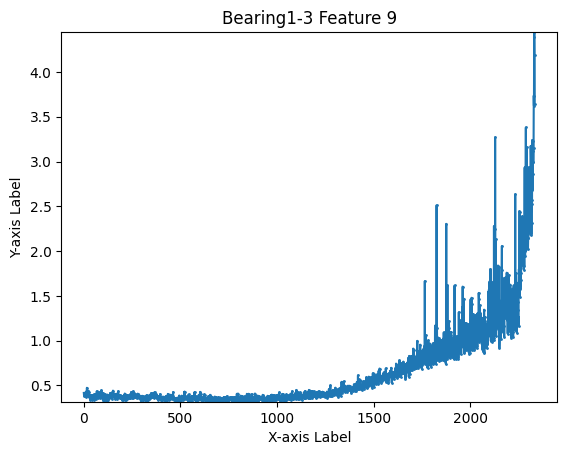

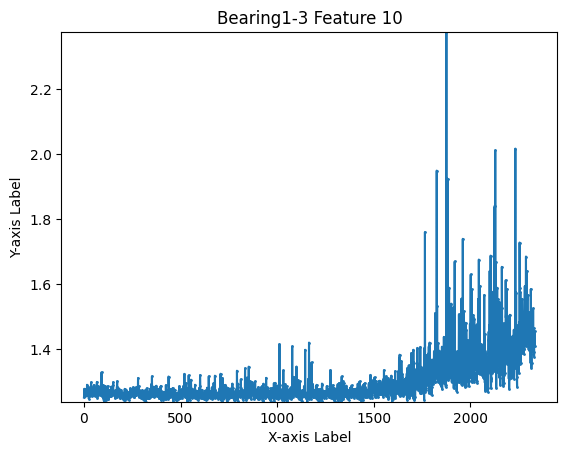

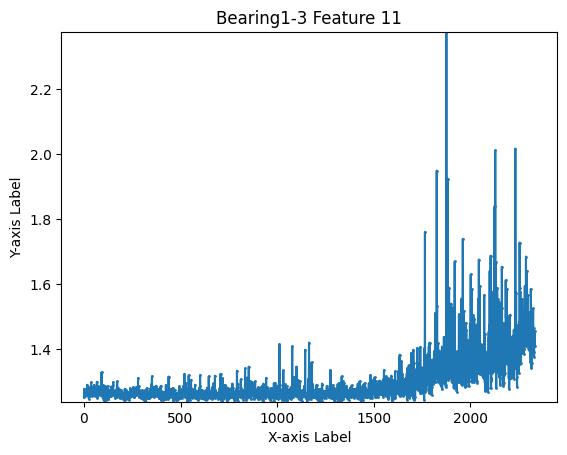

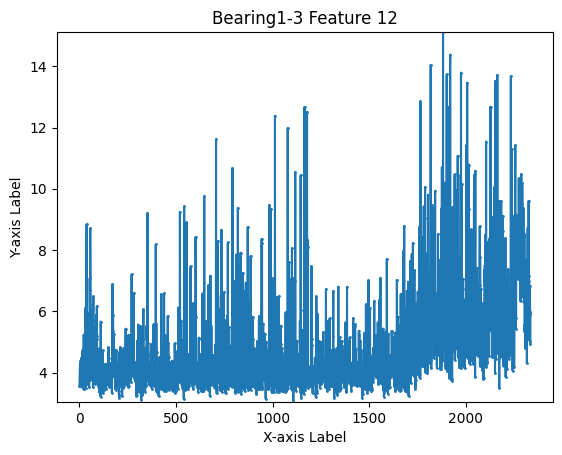

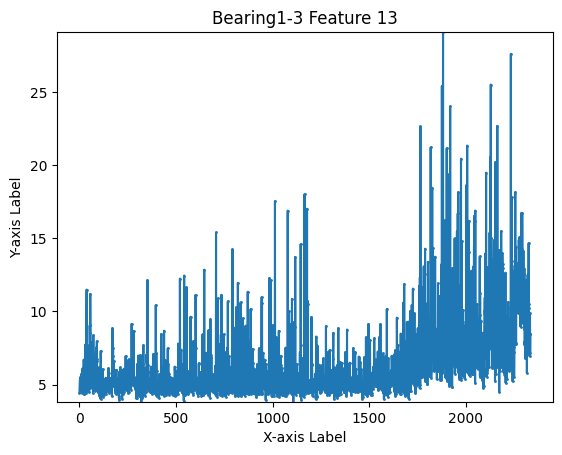

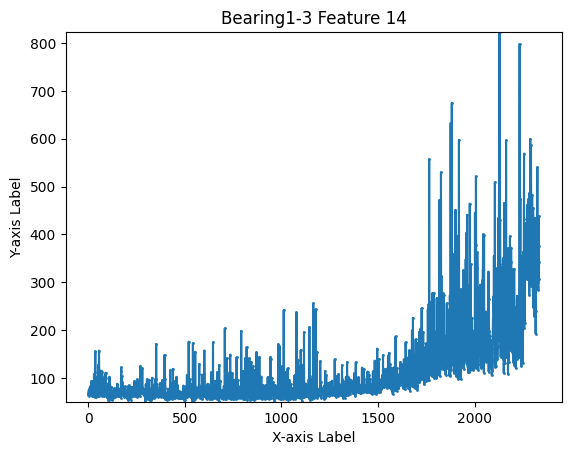

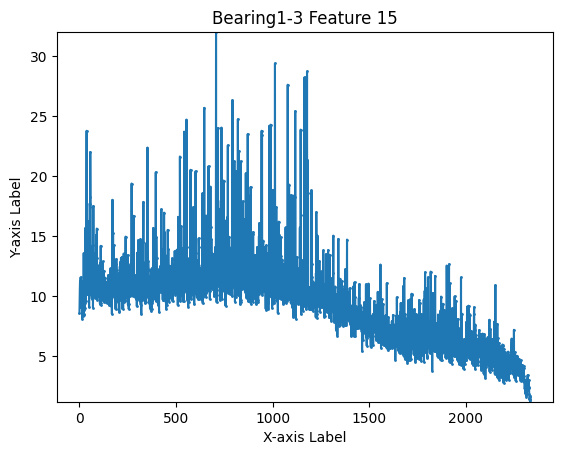

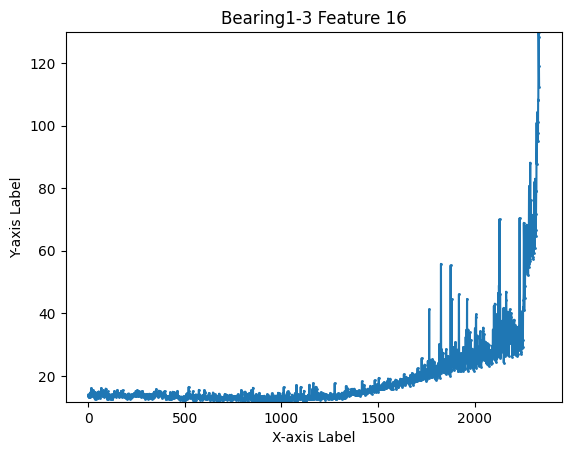

IndexError: index 16 is out of bounds for axis 2 with size 16

In [ ]:
import matplotlib.pyplot as plt

for i in range(20):
# Plotting the line chart
    plt.plot(X_test[:, 0, i], marker='o', markersize=1)
    plt.ylim(min(X_test[:, 0, i]), max(X_test[:, 0, i]))
    plt.xlabel('X-axis Label')
    plt.ylabel('Y-axis Label', )
    plt.title(f'Bearing1-3 Feature {i+1}')
    # Display the plot
    plt.show()